### Install Packages

In [1]:
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')
#!pip install wordcloud

### Import Packages

In [2]:
import nltk
import numpy as np
import re
from nltk import sent_tokenize, word_tokenize, PorterStemmer
from nltk.corpus import stopwords
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from nltk import pos_tag
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from nltk.corpus import wordnet

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Load File Path

In [4]:
# Read the CSV file
df = pd.read_csv("New_York_reviews.csv")

### Original Data Preview

In [5]:
# Original Data Preview
df.head()

,Unnamed: 0,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,city,url_restaurant,author_id
0,1,2,Lido,5,Positive,review_773559838,A Regular Treat,My wife and I have been eating dinner frequent...,My wife and I have been eating dinner frequent...,"October 8, 2020",New_York_City_New_York,https://www.tripadvisor.com/Restaurant_Review-...,UID_0
1,2,3,Lido,4,Positive,review_769429529,Good neighborhood spot!,Came with family for Labor Day weekend brunch ...,Came with family for Labor Day weekend brunch ...,"September 8, 2020",New_York_City_New_York,https://www.tripadvisor.com/Restaurant_Review-...,UID_1
2,3,4,Lido,1,Negative,review_745700258,Disappointing,Food was mediocre at best. The lamb chops are...,Food was mediocre at best. The lamb chops are ...,"February 17, 2020",New_York_City_New_York,https://www.tripadvisor.com/Restaurant_Review-...,UID_2
3,4,5,Lido,5,Positive,review_728859349,What a find in Harlem,My co-workers were volunteering at a foodbank ...,My co-workers were volunteering at a foodbank ...,"November 25, 2019",New_York_City_New_York,https://www.tripadvisor.com/Restaurant_Review-...,UID_3
4,5,6,Lido,5,Positive,review_728429643,Lunch,Lido is an intimate boutique style restaurant....,Lido is an intimate boutique style restaurant....,"November 23, 2019",New_York_City_New_York,https://www.tripadvisor.com/Restaurant_Review-...,UID_4


In [6]:
# Select relevant columns for analysis
df_selected = df[['restaurant_name', 'rating_review', 'sample', 'title_review', 'review_full', 'date', 'city']]

# Display information about the DataFrame
print(df_selected.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510463 entries, 0 to 510462
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   restaurant_name  510463 non-null  object
 1   rating_review    510463 non-null  object
 2   sample           510463 non-null  object
 3   title_review     510462 non-null  object
 4   review_full      510461 non-null  object
 5   date             510461 non-null  object
 6   city             510461 non-null  object
dtypes: object(7)
memory usage: 27.3+ MB
None


In [7]:
# Check the number of occurrences for each class in the 'sample' column
print(df_selected['sample'].value_counts())

Positive                                                                                                                419763
Negative                                                                                                                 90699
https://www.tripadvisor.com/Restaurant_Review-g60763-d477523-Reviews-or290-Rosa_Mexicano-New_York_City_New_York.html         1
Name: sample, dtype: int64


In [8]:
# Review unusual data
df_selected[df_selected['sample']=='https://www.tripadvisor.com/Restaurant_Review-g60763-d477523-Reviews-or290-Rosa_Mexicano-New_York_City_New_York.html']

,restaurant_name,rating_review,sample,title_review,review_full,date,city
300451,"February 5, 2017",New_York_City_New_York,https://www.tripadvisor.com/Restaurant_Review-...,NaN,NaN,NaN,NaN


## Preprocessing Data

In [9]:
# Remove missing values from df_selected
df_selected = df_selected.dropna()

In [10]:
# Convert 'rating_review' to integer
df_selected['rating_review'] = df_selected['rating_review'].astype(int)

In [11]:
# Convert the 'date' column to datetime format
df_selected['date'] = pd.to_datetime(df_selected['date'])

In [12]:
# Drop rows with missing values in 'rating_review' in df_selected
df_selected = df_selected.dropna(subset=['rating_review'])

In [13]:
# Display information about the DataFrame
print(df_selected.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510461 entries, 0 to 510462
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   restaurant_name  510461 non-null  object        
 1   rating_review    510461 non-null  int32         
 2   sample           510461 non-null  object        
 3   title_review     510461 non-null  object        
 4   review_full      510461 non-null  object        
 5   date             510461 non-null  datetime64[ns]
 6   city             510461 non-null  object        
dtypes: datetime64[ns](1), int32(1), object(5)
memory usage: 29.2+ MB
None


In [14]:
# Print dataset after removing missing vales
print(df_selected['sample'].value_counts())

Positive    419762
Negative     90699
Name: sample, dtype: int64


### Balance Data

In [15]:
# Separate majority and minority classes
df_majority = df_selected[df_selected['sample'] == 'Positive']
df_minority = df_selected[df_selected['sample'] == 'Negative']

# Downsample the majority class to match the minority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=61)

# Concatenate the downsampled majority class with the minority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the balanced dataset
df_balanced = df_balanced.sample(frac=1, random_state=61).reset_index(drop=True)

# Print information about the balanced dataset
print("Balanced Dataset Information:")
df_balanced.info()

Balanced Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181398 entries, 0 to 181397
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   restaurant_name  181398 non-null  object        
 1   rating_review    181398 non-null  int32         
 2   sample           181398 non-null  object        
 3   title_review     181398 non-null  object        
 4   review_full      181398 non-null  object        
 5   date             181398 non-null  datetime64[ns]
 6   city             181398 non-null  object        
dtypes: datetime64[ns](1), int32(1), object(5)
memory usage: 9.0+ MB


In [75]:
# df_test = df_balanced

# Define the sample size
sample_size = 5000  # Adjust to desired sample size

# Take out a random part of the data for testing
df_test = df_balanced.sample(n=sample_size, random_state=42).reset_index(drop=True)

# Encoding the target variable
df_test['sentiment'] = df_test['sample'].apply(lambda x: 1 if x == 'Positive' else 0)

# Print information about the test dataset
print("Test Dataset Information:")
df_test.info()

Test Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   restaurant_name  5000 non-null   object        
 1   rating_review    5000 non-null   int32         
 2   sample           5000 non-null   object        
 3   title_review     5000 non-null   object        
 4   review_full      5000 non-null   object        
 5   date             5000 non-null   datetime64[ns]
 6   city             5000 non-null   object        
 7   sentiment        5000 non-null   int64         
dtypes: datetime64[ns](1), int32(1), int64(1), object(5)
memory usage: 293.1+ KB


## Preprocessing Data

In [77]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import re
import pandas as pd
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet

# Download NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# StopWords and Negations
stopword = set(stopwords.words('english'))
negations = {"not", "no", "nor", "neither", "never", "n't"}

# Keep negation for sentimental analysis
stopword = stopword - negations

# Using WordNetLemmatizer for Lemmatization
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to the first character accepted by WordNetLemmatizer"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_text(tokens):
    return ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Han\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Han\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Han\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [78]:
def preprocess_text(text):
    # Tokenization and Lowercasing
    tokens = [re.sub(r'[^a-zA-Z0-9]', '', token).lower() for token in word_tokenize(text)]
    
    # Single Character Removal
    tokens = [token for token in tokens if len(token) > 1]
    
    # Stop-Word Removal
    tokens = [token for token in tokens if token not in stopword]
    
    # POS Tagging and Lemmatization
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
    
    # Stemming using PorterStemmer and LancasterStemmer
    porter = nltk.PorterStemmer()
    lancaster = nltk.LancasterStemmer()
    porter_tokens = [porter.stem(token) for token in tokens]
    lancaster_tokens = [lancaster.stem(token) for token in tokens]
    
    return ' '.join(tokens), ' '.join(porter_tokens), ' '.join(lancaster_tokens)

# Apply preprocessing to 'title_review' and 'review_full' columns in df_test
df_test[['review_title', 'porter_title_review', 'lancaster_title_review']] = df_test['title_review'].apply(preprocess_text).apply(pd.Series)
df_test[['full_review', 'porter_full_review', 'lancaster_full_review']] = df_test['review_full'].apply(preprocess_text).apply(pd.Series)

# Print the updated dataframe
print(df_test.head())

                  restaurant_name  rating_review    sample  \
0  Ariana_Afghan_Kabab_Restaurant              5  Positive   
1                         Felidia              5  Positive   
2                        Blue_Fin              3  Negative   
3                  Cafe_Cranberry              4  Positive   
4               Le_Pain_Quotidien              5  Positive   

                                        title_review  \
0                                   Excellent Dinner   
1                                      great service   
2                  Not bad for the Theater District!   
3  Great cheap place to grab a quick breakfast or...   
4              Great breakfast, would love to return   

                                         review_full       date  \
0  We were recommended this restaurant by the 'Fo... 2018-10-08   
1  I took my wife and son here for his graduation... 2012-07-17   
2  If you are a tourist, please make note that it... 2012-06-22   
3  The western omelett

### POS Tagging

In [79]:
def pos_tag_counter(text):
    try:
        words = word_tokenize(text)
        pos_tags = pos_tag(words, tagset='universal')
        tag_counts = Counter(tag for word, tag in pos_tags)
        return tag_counts
    except (TypeError, AttributeError):
        # Handle cases where the input is not a string (e.g., NaN values)
        return Counter()

# Apply pos_tag_counter to 'full_review' column
df_test['pos_tag_counts'] = df_test['full_review'].apply(pos_tag_counter)

# Create a DataFrame from the resulting Counter objects
pos_counts_df = pd.DataFrame(df_test['pos_tag_counts'].tolist(), index=df_test.index).fillna(0)
pos_counts_df

,NOUN,VERB,ADV,ADP,ADJ,NUM,DET,PRT,.,CONJ,X,PRON
0,13,5.0,4.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13,3.0,6.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,34,16.0,12.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,4.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9,2.0,2.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,34,7.0,10.0,1.0,18.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0
4996,19,1.0,1.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,22,4.0,4.0,3.0,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,13,2.0,1.0,0.0,4.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0


In [80]:
null_pos_reviews = df_test[df_test['pos_tag_counts'].apply(len) == 0]['full_review']
print(null_pos_reviews.head())

Series([], Name: full_review, dtype: object)


### Negation Handling

In [81]:
# Combining the negative word with the word following it
def handle_negations(text):
    negation_words = {"not", "no", "never", "n't", "nor", "none"}
    words = text.split()
    handled_words = []
    negation = False
    for word in words:
        if negation:
            word = "NOT_" + word
            negation = False
        if word in negation_words:
            negation = True
            continue
        handled_words.append(word)
    return ' '.join(handled_words)

df_test['handled_negations'] = df_test['full_review'].apply(handle_negations)
df_test.head()

,restaurant_name,rating_review,sample,title_review,review_full,date,city,sentiment,review_title,porter_title_review,lancaster_title_review,full_review,porter_full_review,lancaster_full_review,pos_tag_counts,handled_negations
0,Ariana_Afghan_Kabab_Restaurant,5,Positive,Excellent Dinner,We were recommended this restaurant by the 'Fo...,2018-10-08,New_York_City_New_York,1,excellent dinner,excel dinner,excel din,recommend restaurant food foot tour guide glad...,recommend restaur food foot tour guid glad wou...,recommend resta food foot tour guid glad would...,"{'NOUN': 13, 'VERB': 5, 'ADV': 4, 'ADP': 1, 'A...",recommend restaurant food foot tour guide glad...
1,Felidia,5,Positive,great service,I took my wife and son here for his graduation...,2012-07-17,New_York_City_New_York,1,great service,great servic,gre serv,take wife son graduation last may heard even r...,take wife son graduat last may heard even rese...,tak wif son gradu last may heard ev reserv wai...,"{'VERB': 3, 'NOUN': 13, 'ADJ': 6, 'ADV': 6}",take wife son graduation last may heard even r...
2,Blue_Fin,3,Negative,Not bad for the Theater District!,"If you are a tourist, please make note that it...",2012-06-22,New_York_City_New_York,0,not bad theater district,not bad theater district,not bad the district,tourist please make note best come broadway se...,tourist pleas make note best come broadway see...,tour pleas mak not best com broadway see show ...,"{'NOUN': 34, 'VERB': 16, 'ADJ': 22, 'ADV': 12}",tourist please make note best come broadway se...
3,Cafe_Cranberry,4,Positive,Great cheap place to grab a quick breakfast or...,The western omelette was excellent. If you li...,2012-09-30,New_York_City_New_York,1,great cheap place grab quick breakfast lunch,great cheap place grab quick breakfast lunch,gre cheap plac grab quick breakfast lunch,western omelette excellent like eat home fry t...,western omelett excel like eat home fri toast ...,western omelet excel lik eat hom fry toast eg ...,"{'ADJ': 2, 'VERB': 4, 'ADP': 1, 'NOUN': 10, 'A...",western omelette excellent like eat home fry t...
4,Le_Pain_Quotidien,5,Positive,"Great breakfast, would love to return",Enjoyed two breakfasts here on a recent NYC tr...,2016-12-07,New_York_City_New_York,1,great breakfast would love return,great breakfast would love return,gre breakfast would lov return,enjoy two breakfast recent nyc trip bake egg f...,enjoy two breakfast recent nyc trip bake egg f...,enjoy two breakfast rec nyc trip bak eg favori...,"{'ADV': 2, 'NUM': 1, 'NOUN': 9, 'ADJ': 5, 'VER...",enjoy two breakfast recent nyc trip bake egg f...


## Sentiment Analysis

### Most Frequent Words

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Function to get the top frequent words using TF-IDF
def get_top_frequent_words(data, max_features=100, ngram_range=(1, 1)):
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    tfidf_result = vectorizer.fit_transform(data)
    tfidf_df = pd.DataFrame(tfidf_result.toarray(), columns=vectorizer.get_feature_names_out())
    binary_tfidf_df = tfidf_df.applymap(lambda x: 1 if x > 0 else 0)
    return tfidf_df, binary_tfidf_df

# Specify max features for review_title and full_review
max_features_title = 200
max_features_full = 300

# Use preprocessed columns for 'review_title' and 'full_review' directly
title_features1, binary_title_feature1 = get_top_frequent_words(df_test['review_title'], max_features=max_features_title)
full_features1, binary_full_feature1 = get_top_frequent_words(df_test['handled_negations'], max_features=max_features_full)

# # Print the updated dataframe
# print(f"Head of the original dataframe:")
# print(df_test.head())

In [83]:
# Print the head of resulting dataframes
print(f"\nHead of TF-IDF score for the most frequent words in 'review_title' (Max Features: {max_features_title}):")
print(title_features1.head())


Head of TF-IDF score for the most frequent words in 'review_title' (Max Features: 200):
   always  amaze  ambiance  ambience  american  atmosphere  authentic  \
0     0.0    0.0       0.0       0.0       0.0         0.0        0.0   
1     0.0    0.0       0.0       0.0       0.0         0.0        0.0   
2     0.0    0.0       0.0       0.0       0.0         0.0        0.0   
3     0.0    0.0       0.0       0.0       0.0         0.0        0.0   
4     0.0    0.0       0.0       0.0       0.0         0.0        0.0   

   average  awesome  awful  ...  way  well  wine  wonderful  worth     would  \
0      0.0      0.0    0.0  ...  0.0   0.0   0.0        0.0    0.0  0.000000   
1      0.0      0.0    0.0  ...  0.0   0.0   0.0        0.0    0.0  0.000000   
2      0.0      0.0    0.0  ...  0.0   0.0   0.0        0.0    0.0  0.000000   
3      0.0      0.0    0.0  ...  0.0   0.0   0.0        0.0    0.0  0.000000   
4      0.0      0.0    0.0  ...  0.0   0.0   0.0        0.0    0.0  0.51

In [84]:
print(f"\nHead of TF-IDF score for the most frequent words in 'full_review' (Max Features: {max_features_full}):")
print(full_features1.head())


Head of TF-IDF score for the most frequent words in 'full_review' (Max Features: 300):
    10   20  actually  add  almost  also  although  always  amaze  another  \
0  0.0  0.0       0.0  0.0     0.0   0.0       0.0     0.0    0.0      0.0   
1  0.0  0.0       0.0  0.0     0.0   0.0       0.0     0.0    0.0      0.0   
2  0.0  0.0       0.0  0.0     0.0   0.0       0.0     0.0    0.0      0.0   
3  0.0  0.0       0.0  0.0     0.0   0.0       0.0     0.0    0.0      0.0   
4  0.0  0.0       0.0  0.0     0.0   0.0       0.0     0.0    0.0      0.0   

   ...      well      wife  wine  without  wonderful  work  worth     would  \
0  ...  0.000000  0.000000   0.0      0.0        0.0   0.0    0.0  0.338764   
1  ...  0.185289  0.291969   0.0      0.0        0.0   0.0    0.0  0.000000   
2  ...  0.177092  0.000000   0.0      0.0        0.0   0.0    0.0  0.000000   
3  ...  0.000000  0.000000   0.0      0.0        0.0   0.0    0.0  0.000000   
4  ...  0.000000  0.000000   0.0      0.0       

### TF_IDF

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

# Get 100 words with the best TF-IDF score from all reviews or titles
# and then check whether each review includes these words
def get_top_tfidf_words(data, max_features=None, top_n=100, ngram_range=(1, 1)):
    # Create a TfidfVectorizer
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    
    # Transform the input data using TF-IDF
    tfidf_result = vectorizer.fit_transform(data)
    
    # Get the indices of features sorted by TF-IDF score
    sorted_indices = np.argsort(tfidf_result.toarray().sum(axis=0))[::-1]
    
    # Get feature names from the vectorizer
    feature_names = np.array(vectorizer.get_feature_names_out())
    
    # Create a DataFrame with the top TF-IDF words
    tfidf_df = pd.DataFrame(tfidf_result.toarray(), columns=vectorizer.get_feature_names_out())
    tfidf_df = tfidf_df[feature_names[sorted_indices[:top_n]]]
    
    # Create a binary DataFrame indicating whether each word is present
    binary_tfidf_df = tfidf_df.applymap(lambda x: 1 if x > 0 else 0)
    
    return tfidf_df, binary_tfidf_df

# Get the top TF-IDF words for both 'review_title' and 'full_review' columns
title_features2, binary_title_feature2 = get_top_tfidf_words(df_test['review_title'], top_n=200)
full_features2, binary_full_feature2 = get_top_tfidf_words(df_test['handled_negations'], top_n=300)

In [86]:
# Print the head of the resulting dataframes
print("Top TF-IDF Words - Title Review:")
print(title_features2.head())

Top TF-IDF Words - Title Review:
   food     great  good   service       not     place  average  excellent  \
0   0.0  0.000000   0.0  0.000000  0.000000  0.000000      0.0    0.69715   
1   0.0  0.656389   0.0  0.754422  0.000000  0.000000      0.0    0.00000   
2   0.0  0.000000   0.0  0.000000  0.336582  0.000000      0.0    0.00000   
3   0.0  0.203337   0.0  0.000000  0.000000  0.274449      0.0    0.00000   
4   0.0  0.248853   0.0  0.000000  0.000000  0.000000      0.0    0.00000   

   breakfast  nice  ...  rat  comfort  district  trip  heaven  enough  \
0   0.000000   0.0  ...  0.0      0.0  0.000000   0.0     0.0     0.0   
1   0.000000   0.0  ...  0.0      0.0  0.000000   0.0     0.0     0.0   
2   0.000000   0.0  ...  0.0      0.0  0.603506   0.0     0.0     0.0   
3   0.313687   0.0  ...  0.0      0.0  0.000000   0.0     0.0     0.0   
4   0.383905   0.0  ...  0.0      0.0  0.000000   0.0     0.0     0.0   

   steakhouse  superb  theatre  cafe  
0         0.0     0.0     

In [87]:
print("\nTop TF-IDF Words - Full Review:")
print(full_features2.head())


Top TF-IDF Words - Full Review:
     food      good   service  place     great  restaurant        go  \
0  0.1315  0.000000  0.000000    0.0  0.092390    0.177633  0.000000   
1  0.0000  0.000000  0.073389    0.0  0.000000    0.000000  0.000000   
2  0.0000  0.080479  0.000000    0.0  0.096964    0.046607  0.139529   
3  0.0000  0.000000  0.000000    0.0  0.000000    0.000000  0.000000   
4  0.0000  0.195743  0.100026    0.0  0.000000    0.000000  0.000000   

         nt     time       get  ...  kind  half  welcome  open  four  dry  \
0  0.000000  0.00000  0.000000  ...   0.0   0.0      0.0   0.0   0.0  0.0   
1  0.000000  0.00000  0.000000  ...   0.0   0.0      0.0   0.0   0.0  0.0   
2  0.149587  0.05259  0.053860  ...   0.0   0.0      0.0   0.0   0.0  0.0   
3  0.000000  0.00000  0.114107  ...   0.0   0.0      0.0   0.0   0.0  0.0   
4  0.000000  0.00000  0.000000  ...   0.0   0.0      0.0   0.0   0.0  0.0   

   second  sunday  rather       may  
0     0.0     0.0     0.0  0.0000

### N-Grams

In [88]:
# Using above two functions to find bigram and trigram features for each review title
title_features3, binary_title_feature3 = get_top_frequent_words(df_test['review_title'], max_features=200, ngram_range=(2, 3))
title_features4, binary_title_feature4 = get_top_tfidf_words(df_test['review_title'], top_n=200, ngram_range=(2, 3))

# Using above two functions to find bigram and trigram features for each full review
full_features3, binary_full_feature3 = get_top_frequent_words(df_test['handled_negations'], max_features=300, ngram_range=(2, 3))
full_features4, binary_full_feature4 = get_top_tfidf_words(df_test['handled_negations'], top_n=300, ngram_range=(2, 3))

In [89]:
print("Top N-Grams Words - Title Review:")
print(title_features4.head())

Top N-Grams Words - Title Review:
   great food  good food  not good  poor service  new york  nothing special  \
0         0.0        0.0       0.0           0.0       0.0              0.0   
1         0.0        0.0       0.0           0.0       0.0              0.0   
2         0.0        0.0       0.0           0.0       0.0              0.0   
3         0.0        0.0       0.0           0.0       0.0              0.0   
4         0.0        0.0       0.0           0.0       0.0              0.0   

   not worth  average food  great place  great service  ...  great deli  \
0        0.0           0.0          0.0            0.0  ...         0.0   
1        0.0           0.0          0.0            1.0  ...         0.0   
2        0.0           0.0          0.0            0.0  ...         0.0   
3        0.0           0.0          0.0            0.0  ...         0.0   
4        0.0           0.0          0.0            0.0  ...         0.0   

   excellent breakfast  incredible food 

In [90]:
print("\nTop N-Grams Words - Full Review:")
print(full_features4.head())


Top N-Grams Words - Full Review:
   new york  food good  go back  service good  good service  good food  ca nt  \
0  0.058677        0.0      0.0           0.0      0.000000        0.0    0.0   
1  0.000000        0.0      0.0           0.0      0.000000        0.0    0.0   
2  0.000000        0.0      0.0           0.0      0.000000        0.0    0.0   
3  0.000000        0.0      0.0           0.0      0.000000        0.0    0.0   
4  0.000000        0.0      0.0           0.0      0.088511        0.0    0.0   

   great food  highly recommend  come back  ...  food price  \
0     0.07853          0.075808        0.0  ...         0.0   
1     0.00000          0.000000        0.0  ...         0.0   
2     0.00000          0.000000        0.0  ...         0.0   
3     0.00000          0.000000        0.0  ...         0.0   
4     0.00000          0.000000        0.0  ...         0.0   

   food great service  sit bar  give try  trip advisor  visit restaurant  \
0                 0.0   

### Length

In [91]:
# Get the length of each review
df_test['length_review'] = df_test['full_review'].apply(len)
df_test['length_title'] = df_test['review_title'].apply(len)

# Print the head of the resulting dataframe
print(df_test.head())

                  restaurant_name  rating_review    sample  \
0  Ariana_Afghan_Kabab_Restaurant              5  Positive   
1                         Felidia              5  Positive   
2                        Blue_Fin              3  Negative   
3                  Cafe_Cranberry              4  Positive   
4               Le_Pain_Quotidien              5  Positive   

                                        title_review  \
0                                   Excellent Dinner   
1                                      great service   
2                  Not bad for the Theater District!   
3  Great cheap place to grab a quick breakfast or...   
4              Great breakfast, would love to return   

                                         review_full       date  \
0  We were recommended this restaurant by the 'Fo... 2018-10-08   
1  I took my wife and son here for his graduation... 2012-07-17   
2  If you are a tourist, please make note that it... 2012-06-22   
3  The western omelett

### Concat features

In [92]:
# # Title Review features
# title_features1, binary_title_feature1 = get_top_frequent_words(df_test['review_title'], max_features=200)
# title_features2, binary_title_feature2 = get_top_tfidf_words(df_test['review_title'], top_n=200)
# title_features3, binary_title_feature3 = get_top_frequent_words(df_test['review_title'], max_features=200, ngram_range=(2, 3))
# title_features4, binary_title_feature4 = get_top_tfidf_words(df_test['review_title'], top_n=200, ngram_range=(2, 3))

title_feature = pd.concat([title_features2, title_features4, title_features1, title_feature3], axis=1)
title_feature = title_feature.loc[:, ~title_feature.columns.duplicated()]
title_feature.info()

# Print the head of the resulting title features dataframe
print(title_feature.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 642 entries, food to york city
dtypes: float64(642)
memory usage: 24.5 MB
   food     great  good   service       not     place  average  excellent  \
0   0.0  0.000000   0.0  0.000000  0.000000  0.000000      0.0    0.69715   
1   0.0  0.656389   0.0  0.754422  0.000000  0.000000      0.0    0.00000   
2   0.0  0.000000   0.0  0.000000  0.336582  0.000000      0.0    0.00000   
3   0.0  0.203337   0.0  0.000000  0.000000  0.274449      0.0    0.00000   
4   0.0  0.248853   0.0  0.000000  0.000000  0.000000      0.0    0.00000   

   breakfast  nice  ...  would expect  would go  would go back  would like  \
0   0.000000   0.0  ...           0.0       0.0            0.0         0.0   
1   0.000000   0.0  ...           0.0       0.0            0.0         0.0   
2   0.000000   0.0  ...           0.0       0.0            0.0         0.0   
3   0.313687   0.0  ...           0.0       0.0            0.0      

In [93]:
# Full Review features
# full_features1, binary_full_feature1 = get_top_frequent_words(df_test['handled_negations'], max_features=300)
# full_features2, binary_full_feature2 = get_top_tfidf_words(df_test['handled_negations'], top_n=300)
# full_features3, binary_full_feature3 = get_top_frequent_words(df_test['handled_negations'], max_features=300, ngram_range=(2, 3))
# full_features4, binary_full_feature4 = get_top_tfidf_words(df_test['handled_negations'], top_n=300, ngram_range=(2, 3))

full_feature = pd.concat([full_features2, full_features4, full_features1, full_features3], axis=1)
full_feature = full_feature.loc[:, ~full_feature.columns.duplicated()]
full_feature.info()

# Print the head of the resulting full features dataframe
print(full_feature.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 652 entries, food to year old
dtypes: float64(652)
memory usage: 24.9 MB
     food      good   service  place     great  restaurant        go  \
0  0.1315  0.000000  0.000000    0.0  0.092390    0.177633  0.000000   
1  0.0000  0.000000  0.073389    0.0  0.000000    0.000000  0.000000   
2  0.0000  0.080479  0.000000    0.0  0.096964    0.046607  0.139529   
3  0.0000  0.000000  0.000000    0.0  0.000000    0.000000  0.000000   
4  0.0000  0.195743  0.100026    0.0  0.000000    0.000000  0.000000   

         nt     time       get  ...  restaurant would  sea bass  seat table  \
0  0.000000  0.00000  0.000000  ...               0.0       0.0         0.0   
1  0.000000  0.00000  0.000000  ...               0.0       0.0         0.0   
2  0.149587  0.05259  0.053860  ...               0.0       0.0         0.0   
3  0.000000  0.00000  0.114107  ...               0.0       0.0         0.0   
4  0.000000  0.0

In [94]:
# All Review features
combined_features = pd.concat([title_feature, full_feature, pos_counts_df, df_test['length_review'], df_test['length_title']], axis=1)
combined_features.info()

# Print the head of the resulting combined features dataframe
print(combined_features.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 1308 entries, food to length_title
dtypes: float64(1305), int64(3)
memory usage: 49.9 MB
   food     great  good   service       not     place  average  excellent  \
0   0.0  0.000000   0.0  0.000000  0.000000  0.000000      0.0    0.69715   
1   0.0  0.656389   0.0  0.754422  0.000000  0.000000      0.0    0.00000   
2   0.0  0.000000   0.0  0.000000  0.336582  0.000000      0.0    0.00000   
3   0.0  0.203337   0.0  0.000000  0.000000  0.274449      0.0    0.00000   
4   0.0  0.248853   0.0  0.000000  0.000000  0.000000      0.0    0.00000   

   breakfast  nice  ...   ADJ  NUM  DET  PRT    .  CONJ    X  PRON  \
0   0.000000   0.0  ...   6.0  0.0  0.0  0.0  0.0   0.0  0.0   0.0   
1   0.000000   0.0  ...   6.0  0.0  0.0  0.0  0.0   0.0  0.0   0.0   
2   0.000000   0.0  ...  22.0  0.0  0.0  0.0  0.0   0.0  0.0   0.0   
3   0.313687   0.0  ...   2.0  0.0  0.0  0.0  0.0   0.0  0.0   0.0   
4   0.383905   

### Split Data for Training Models

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Use the first 'sample_size' samples from x
x = combined_features[:sample_size]
y = df_test['sentiment'][:sample_size]

# Fill missing values in x
x.fillna(0, inplace=True)

# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=61)

# Uncomment the following lines if you choose to use StandardScaler
# scaler = StandardScaler()
# x_scaled = scaler.fit_transform(x)
# x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3, random_state=61)

### Random Forest

In [96]:
# Random Forest Model
model = RandomForestClassifier(random_state=61)

# Training the Model
model.fit(x_train, y_train)

# Making Predictions
predictions = model.predict(x_test)

# Evaluation Metrics
# Classification Report
print("Classification Report:")
print(classification_report(y_test, predictions))

# Accuracy Score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       738
           1       0.85      0.84      0.84       762

    accuracy                           0.84      1500
   macro avg       0.84      0.84      0.84      1500
weighted avg       0.84      0.84      0.84      1500

Accuracy: 0.8413333333333334


### Feature Selection

In [34]:
# Feature Selection using Recursive Feature Elimination (RFE) with a Random Forest Classifier

# WARNING: TIME-CONSUMING OPERATION!
# The RFE feature selection may take a considerable amount of time.

# Create an RFE selector with a Random Forest Classifier as the estimator
selector = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=61), n_features_to_select=50, step=1)

# Fit the RFE selector on the training data
selector = selector.fit(x_train, y_train)

# Transform the training and testing sets to keep only selected features
x_train_selected = selector.transform(x_train)
x_test_selected = selector.transform(x_test)

# Create a new Random Forest Classifier model
model = RandomForestClassifier(random_state=61)

# Fit the model using the training data with selected features
model.fit(x_train_selected, y_train)

# Evaluate the model on the testing data with selected features
accuracy = model.score(x_test_selected, y_test)

# Print the accuracy of the model with selected features
print("Accuracy with selected features: ", accuracy)

Accuracy with selected features:  0.7753333333333333


### GridSearch

In [35]:
# GridSearch for Hyperparameter Tuning with Random Forest

# WARNING: TIME-CONSUMING OPERATION!
# The GridSearchCV operation may take a considerable amount of time.

# Define the parameter grid for the Random Forest model
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}

# Create a Random Forest Classifier with a fixed random state for consistency
rf = RandomForestClassifier(random_state=61)

# Initialize the Grid Search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the Grid Search model on the training data
grid_search.fit(x_train, y_train)

# Print the best parameters found by the Grid Search
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the best model on the testing data
best_model = grid_search.best_estimator_
accuracy = best_model.score(x_test, y_test)

# Print the accuracy of the best model
print("Accuracy of the best model: ", accuracy)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters found:  {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 300}
Accuracy of the best model:  0.842


### Restaurant Tag
We want to group reviews by restaurant name and use TF-IDF to find 20 most important words or bigrams as tags for each restaurant.

In [36]:
# Restaurant Tagging using TF-IDF with df_test

# Display information about the dataset
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 106495 to 35366
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   restaurant_name         5000 non-null   object        
 1   rating_review           5000 non-null   int32         
 2   sample                  5000 non-null   object        
 3   title_review            5000 non-null   object        
 4   review_full             5000 non-null   object        
 5   date                    5000 non-null   datetime64[ns]
 6   city                    5000 non-null   object        
 7   sentiment               5000 non-null   int64         
 8   review_title            5000 non-null   object        
 9   porter_title_review     5000 non-null   object        
 10  lancaster_title_review  5000 non-null   object        
 11  full_review             5000 non-null   object        
 12  porter_full_review      5000 non-null   ob

In [37]:
# Group reviews by restaurant name, combining title reviews, full reviews, and calculating mean rating
grouped_reviews = df_test.groupby('restaurant_name').apply(
    lambda x: pd.Series({
        'combined_reviews': ';'.join(x['review_title'] + ' ' + x['full_review']),
        'mean_rate': round(x['rating_review'].mean(), 2)
    })).reset_index()

# Print head of grouped_reviews
print("\nHead of grouped_reviews:")
print(grouped_reviews.head())


Head of grouped_reviews:
   restaurant_name                                   combined_reviews  \
0        12_Chairs  pita bread friend recommend go 12 chair say lo...   
1          21_Club  nice high expectation read history place like ...   
2        230_Fifth  not good expect guess high expectation place g...   
3  2nd_Avenue_Deli  average food pricey food average not really wo...   
4             44_X  fantastic space friend new york city nt know e...   

   mean_rate  
0       4.00  
1       3.10  
2       2.74  
3       4.44  
4       4.17  


In [38]:
from nltk.stem import PorterStemmer

porter = PorterStemmer()

# Function to filter out non-nouns and non-adjectives, and apply stemming
def filter_nouns_adj(text):
    stopword = set(stopwords.words('english'))    
    words = word_tokenize(text)
    vocab = [w.lower() for w in words if w.lower() not in stopword and w.isalpha() and w.lower() not in ['new york', 'york', 'nyc', 'restaurant', 'food', 'place', 'drink']]
    pos_tags = pos_tag(vocab, tagset='universal')
    return ' '.join([porter.stem(word) for word, tag in pos_tags if tag == 'NOUN'])


# Apply filtering to create a new column 'filtered_reviews'
grouped_reviews['filtered_reviews'] = grouped_reviews['combined_reviews'].apply(filter_nouns_adj)

# Print head of 'filtered_reviews'
print("\nHead of 'filtered_reviews':")
print(grouped_reviews['filtered_reviews'].head())


Head of 'filtered_reviews':
0    bread friend order life hummu pita move israel...
1    expect histori head state grace din room somet...
2    expect guess expect servic view fenc look view...
3    price price rate point servic restroom experi ...
4    space citi nt servic venu remind market hype b...
Name: filtered_reviews, dtype: object


In [39]:
# Function to extract top words using TF-IDF
def tag_words(text, tag_index, max_features=5000, top_n=20, ngram_range=(1, 2)):
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range) 
    tfidf_result = vectorizer.fit_transform(text)

    words = vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame(tfidf_result.toarray(), columns=words, index=tag_index)

    top_words_dict = {}
    for restaurant in tfidf_df.index:
        top_words = tfidf_df.loc[restaurant].nlargest(top_n).index.tolist()
        top_words_dict[restaurant] = top_words

    return top_words_dict

In [40]:
# Apply the tagging function
restaurant_tags = tag_words(grouped_reviews['filtered_reviews'], grouped_reviews['restaurant_name'])

# Print the tags for each restaurant
for restaurant, tags in restaurant_tags.items():
    print(f"\nRestaurant: {restaurant}, Tags: {tags}")

    # Print top words for each restaurant
    top_words = grouped_reviews[grouped_reviews['restaurant_name'] == restaurant]['filtered_reviews'].iloc[0]
    print(f"Top Words for {restaurant}: {top_words}\n")


Restaurant: 12_Chairs, Tags: ['pita', 'bread', 'live', 'hummu', 'friend order', 'complain', 'chair', 'life', 'move', 'weekend', 'friend', 'order', 'abc', 'abil', 'absolut', 'abund', 'ac', 'accent', 'access', 'accid']
Top Words for 12_Chairs: bread friend order life hummu pita move israel complain paperi pita bread live israel weekend chair


Restaurant: 21_Club, Tags: ['wine', 'winc', 'room', 'grace', 'experi', 'club', 'clever', 'jacket', 'bar', 'din', 'band', 'menu', 'busi', 'choic', 'toward', 'beverag', 'reserv', 'grab', 'histori', 'ceil']
Top Words for 21_Club: expect histori head state grace din room someth cut wife coupl friend california treat occas meal reserv way advanc treat grace tabl bar problem staff feel hour reserv wine price wine captain felt portion size present wait staff formal encount bar requir bartend grab water help dilut grab friend impress busi bit fun night friend opinion school school nci servic cesar salad crab cake crab world mushroom risotto filet risotto 

Restaurant: Feast, Tags: ['rice ball', 'fun', 'mmm', 'fri crispi', 'end servic', 'famili style', 'servic way', 'chunk', 'sea bass', 'bass', 'brussel', 'ball', 'appl', 'sea', 'crispi', 'medium', 'bacon', 'case', 'pricey', 'ice']
Top Words for Feast: pricey tast compon fun cocktail fun chunk ice famili style arroncini case rice ball tender brussel portion sea bass lacquer steak ok medium bacon mmm taro fri crispi appl share end servic way nice servic


Restaurant: Feinstein_s_54_Below, Tags: ['coat', 'venu', 'forc', 'bar area', 'bar', 'person', 'check coat', 'seat bit', 'tip', 'show', 'order servic', 'seat time', 'time bar', 'bar seat', 'improv', 'that', 'twist', 'bother', 'area', 'take order']
Top Words for Feinstein_s_54_Below: visit broadway review feinstein show disappoint show issu venu fact person parti end appet alon way worth seat time v time bar seat bit view twist chair space everyon venu anyon take order servic bar area anyth thing bother forc check coat that oblig tip coat pe



Restaurant: Mary_s_Fish_Camp, Tags: ['eas', 'night book', 'tast wine', 'approach', 'choos', 'dinner night', 'warm', 'villag', 'gem', 'life', 'roll', 'book', 'dish', 'wine', 'friend', 'tast', 'night', 'dinner', 'servic', 'abc']
Top Words for Mary_s_Fish_Camp: gem friend life villag dinner night book servic warm approach eas dish roll tast wine choos


Restaurant: Mas_farmhouse, Tags: ['cours', 'portion', 'situat', 'pleasant', 'tast', 'ask coffe', 'pleasant dinner', 'portion cours', 'portion person', 'side price', 'tast beef', 'fennel', 'half price', 'skimpi', 'coupl', 'check ask', 'express', 'femal', 'acknowledg', 'brought']
Top Words for Mas_farmhouse: way ambienc charm hostess portion skimpi tast portion person side price rock cours tast menu thank god bread tip musett tast beef adventuresom chef dont order menu pleasant dinner surround screen ambianc pleasant villag locat servic cours gap acknowledg cours portion cours servic thing consid rate neighborhood destin year coupl reserv 



Restaurant: Skyline_Gourmet_Deli, Tags: ['croissant', 'look bit', 'order chocol', 'car', 'tri order', 'textur', 'ice', 'chocol', 'expect', 'water', 'bit', 'look', 'tri', 'tast', 'order', 'abc', 'abil', 'absolut', 'abund', 'ac']
Top Words for Skyline_Gourmet_Deli: expect tri order chocol croissant croissant textur car tyre ice tast water look bit


Restaurant: Smith_Wollensky, Tags: ['steak', 'smith', 'waiter', 'smith wollenski', 'waiter wife', 'wollenski', 'wife', 'point', 'jacket', 'sister', 'walk', 'steakhous', 'lack staff', 'review menu', 'coat', 'environ', 'rib steak', 'servic', 'menu waiter', 'walk door']
Top Words for Smith_Wollensky: meal visit joint birthday men sister dinner side macaroni look hour sauc staff meal sister steak dinner servic desert mind visit occas time ribey accompani cream spinach mac asparagu steak lack staff steak lack staff show age age trip year absenc price averag citi steakhous side everyth steak qualiti servic time other figur servic price menu desse

Top Words for Tim_Ho_Wan_East_Village: dim sum tim ho wan serf dim item price dim sum chinatown tim ho wan dish tast item pork bun crispi textur fill waitslin hope dim sum tast servic okay sum tri peril


Restaurant: Times_Square_Diner_Grill, Tags: ['breakfast', 'diner', 'servic', 'servic enjoy', 'size portion', 'teenag', 'portion', 'breakfast breakfast', 'wait', 'omelett', 'staff', 'explain', 'wait minut', 'girl', 'enjoy', 'servic price', 'day', 'stop', 'tri', 'habit']
Top Words for Times_Square_Diner_Grill: town soak rain stop catch theater servic stop day breakfast valu staff size portion fact day kid ice cream lunch get weekend staff effici servic price locat conveni locat teenag servic price portion diner time section midtown manhattan march day wait tabl line wait minut staff coffe refil omelett hous potato bagel nt cost arm leg eat order lunch burger wrap look mean servic rush qualiti averag hand bill tri diner way breakfast breakfast wait minut servic enjoy omelett breakfast ev

## Data Analysis and Visualizations

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Restaurant Ratings Statistics

In [42]:
### Build Review Ratings Stats

# Group by restaurant and calculate statistics
review_stats = df_test.groupby('restaurant_name')['rating_review'].agg(['count', 'mean', 'max', 'min', 'median'])

# Get the top 15 restaurants with the highest number of reviews
top_15_reviews = review_stats.nlargest(15, 'count')

# Print information about the new dataset
print("Information about the new dataset based on restaurant ratings:")
print("Number of restaurants:", len(review_stats))
print("Number of reviews per restaurant:")
print(top_15_reviews[['count', 'mean', 'max', 'min', 'median']])

Information about the new dataset based on restaurant ratings:
Number of restaurants: 1056
Number of reviews per restaurant:
                                           count      mean  max  min  median
restaurant_name                                                             
Carmine_s_Italian_Restaurant_Times_Square     66  3.757576    5    1     4.0
Brooklyn_Diner                                40  3.375000    5    1     3.0
Ellen_s_Stardust_Diner                        39  3.358974    5    1     3.0
TAO_Uptown                                    36  3.333333    5    1     3.0
Le_Pain_Quotidien                             35  3.428571    5    1     3.0
Eataly                                        34  3.617647    5    1     3.0
Loeb_Boathouse_Central_Park                   34  3.000000    5    1     3.0
Tick_Tock_Diner_NY                            34  3.294118    5    1     3.0
Bill_s_Bar_Burger                             33  3.303030    5    1     3.0
The_View_Restaurant_Lounge  

In [43]:
# Displaying the head of the review_stats DataFrame to inspect the calculated statistics for each restaurant
review_stats.head()

,count,mean,max,min,median
restaurant_name,,,,,
12_Chairs,1,4.000000,4,4,4.0
21_Club,10,3.100000,5,2,3.0
230_Fifth,19,2.736842,5,1,3.0
2nd_Avenue_Deli,9,4.444444,5,3,5.0
44_X,6,4.166667,5,3,4.5


### Distribution of Number of Reviews per Restaurant

Max Reviews: 66
Min Reviews: 1
Median Reviews: 3.0


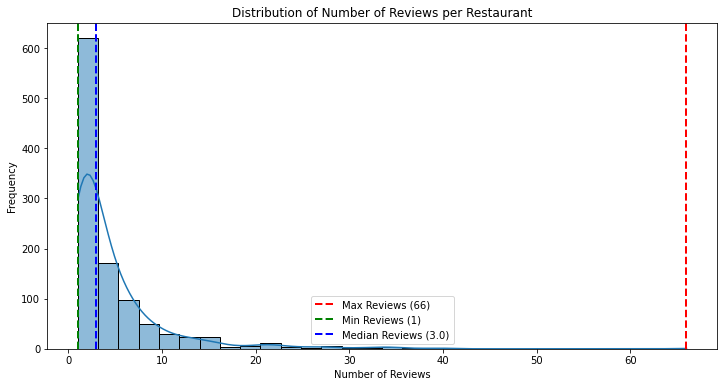

In [44]:
# Calculate statistics on the number of reviews per restaurant
max_reviews = review_stats['count'].max()
min_reviews = review_stats['count'].min()
median_reviews = review_stats['count'].median()

# Print the results
print("Max Reviews:", max_reviews)
print("Min Reviews:", min_reviews)
print("Median Reviews:", median_reviews)

# Visualize the distribution
plt.figure(figsize=(12, 6))
sns.histplot(df_test.groupby('restaurant_name')['rating_review'].count(), bins=30, kde=True)
plt.title("Distribution of Number of Reviews per Restaurant")
plt.xlabel("Number of Reviews")
plt.ylabel("Frequency")
plt.axvline(max_reviews, color='red', linestyle='dashed', linewidth=2, label=f'Max Reviews ({max_reviews})')
plt.axvline(min_reviews, color='green', linestyle='dashed', linewidth=2, label=f'Min Reviews ({min_reviews})')
plt.axvline(median_reviews, color='blue', linestyle='dashed', linewidth=2, label=f'Median Reviews ({median_reviews})')
plt.legend()
plt.show()

### Top 15 Restaurants with the Highest Number of Reviews

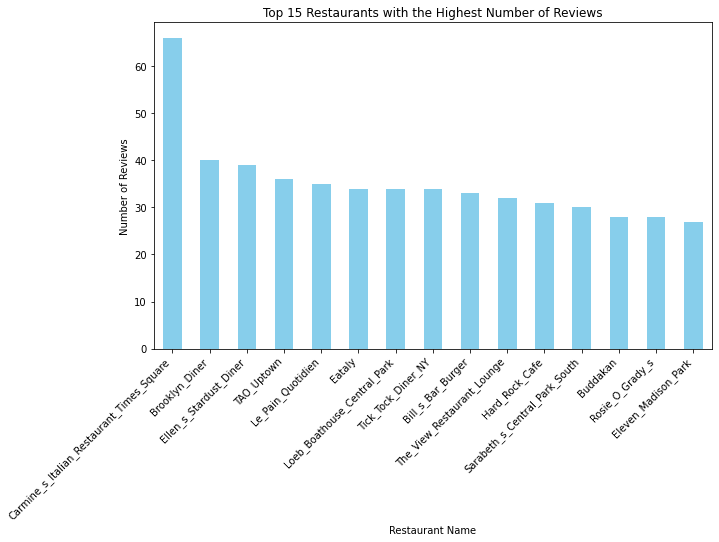

In [45]:
# Visualize the top 15 restaurants with the highest number of reviews in df_test
plt.figure(figsize=(10, 6))
df_test.groupby('restaurant_name')['rating_review'].count().nlargest(15).plot(kind='bar', color='skyblue')
plt.title('Top 15 Restaurants with the Highest Number of Reviews')
plt.xlabel('Restaurant Name')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

### Distribution of Average Rating of Restaurants

In [46]:
# Calculate the mean of the mean ratings across all restaurants in df_test
mean_rating = review_stats['mean'].mean()

# Print the result
print("Mean of Mean Ratings of Restaurants:", mean_rating)

Mean of Mean Ratings of Restaurants: 3.566277528997003


Mean Rating for Restaurants with More Than 4.73 Reviews: 3.519387622283688
Number of Restaurants with More Than Mean Reviews: 339


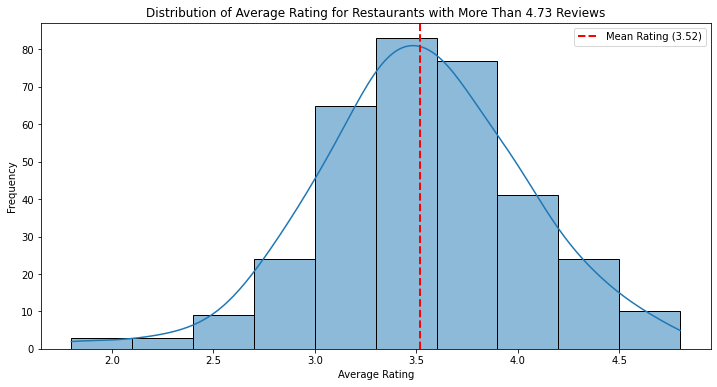

In [47]:
# Calculate the mean number of reviews
mean_reviews = review_stats['count'].mean()

# Calculate the mean rating for restaurants with more than the mean number of reviews
mean_rating_condition = review_stats['count'] > mean_reviews
mean_rating = review_stats[mean_rating_condition]['mean'].mean()

# Print the result and some additional information
print(f"Mean Rating for Restaurants with More Than {mean_reviews:.2f} Reviews:", mean_rating)
print("Number of Restaurants with More Than Mean Reviews:", sum(mean_rating_condition))

# Visualize the distribution of average ratings
plt.figure(figsize=(12, 6))
sns.histplot(review_stats[mean_rating_condition]['mean'], bins=10, kde=True)
plt.title(f"Distribution of Average Rating for Restaurants with More Than {mean_reviews:.2f} Reviews")
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.axvline(mean_rating, color='red', linestyle='dashed', linewidth=2, label=f'Mean Rating ({mean_rating:.2f})')
plt.legend()
plt.show()

### Average Rating of Top 15 Restaurants

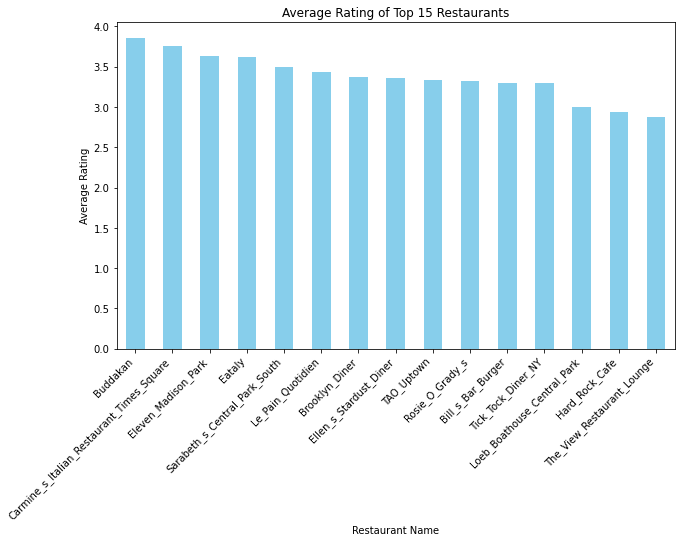

In [48]:
# Visualize the average rating of the top 15 restaurants from largest to least
plt.figure(figsize=(10, 6))

# Sort the DataFrame by 'mean' column in descending order
top_15_reviews_sorted = top_15_reviews.sort_values(by='mean', ascending=False)

# Plotting a bar chart for the mean rating of the top 15 restaurants
top_15_reviews_sorted['mean'].plot(kind='bar', color='skyblue')

# Adding title and labels to the plot
plt.title('Average Rating of Top 15 Restaurants')
plt.xlabel('Restaurant Name')
plt.ylabel('Average Rating')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()

### Trend of Average Rating by Year

In [49]:
# Extract Year-Month information from the 'date' column
df_test['year_month'] = df_test['date'].dt.to_period('M')

# Group by restaurant and Year_Month to calculate the mean rating for each restaurant in each month
df_rating_trend = df_test.groupby(['restaurant_name', 'year_month'])['rating_review'].mean().reset_index()

# Sort the DataFrame by 'year_month' for chronological order
df_rating_trend = df_rating_trend.sort_values('year_month')

# Print the resulting dataframe
print("DataFrame with Average Rating for Each Restaurant in Each Month:")
print(df_rating_trend.head())

DataFrame with Average Rating for Each Restaurant in Each Month:
                           restaurant_name year_month  rating_review
3601                       Sarabeth_s_West    2004-07            5.0
171                         Angelo_s_Pizza    2004-08            4.0
3914                      Taverna_di_Bacco    2005-04            5.0
1322  Del_Frisco_s_Double_Eagle_Steakhouse    2006-01            3.0
4666                 Wolfgang_s_Steakhouse    2006-01            2.0


In [53]:
def avg_rating_trend(df_test, restaurants_list, year_list):
    """
    Plot the monthly average ratings trend for selected restaurants and years.
    
    Parameters:
        df_test (DataFrame): The DataFrame containing the average ratings for each restaurant in each month.
        restaurants_list (list): List of restaurant names to include in the plot.
        year_list (list): List of years to include in the plot.
    
    Returns:
        None
    """
    # Print selected restaurants and years
    print("Selected Restaurants:", restaurants_list)
    print("Selected Years:", year_list)
    
    # Make sure restaurants_list and year_list are lists
    plt.figure(figsize=(12, 6))
    for restaurant in restaurants_list:
        # Filter the DataFrame
        selected_df = df_test[df_test['restaurant_name'] == restaurant]
        selected_df = selected_df[selected_df['year_month'].dt.year.isin(year_list)]
        
        # Convert 'year_month' to string and then to datetime
        selected_df['year_month'] = pd.to_datetime(selected_df['year_month'].astype(str))
        selected_df = selected_df.sort_values('year_month')

        # Plot the average ratings trend
        plt.plot(selected_df['year_month'], selected_df['rating_review'], label=restaurant)

    # Adding index as text on each data point (if needed)
    # for i, restaurant in enumerate(restaurants_list):
    #     for j, txt in enumerate(selected_df['rating_review'].astype(str)):
    #         plt.annotate(txt, (selected_df['year_month'].astype(str)[j], selected_df['rating_review'].values[j]))

    plt.title('Monthly Average Ratings Over Time')
    plt.xlabel('Year Month')
    plt.ylabel('Average Rating')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.show()

# Example usage:
# avg_rating_trend(df_test, ['Restaurant1', 'Restaurant2'], [2019, 2020])

### Top 3 Restaurants with Most Reviews from 2019-2021

Top Restaurants: Index(['Carmine_s_Italian_Restaurant_Times_Square', 'Brooklyn_Diner',
       'Ellen_s_Stardust_Diner'],
      dtype='object', name='restaurant_name')
Selected Restaurants: Index(['Carmine_s_Italian_Restaurant_Times_Square', 'Brooklyn_Diner',
       'Ellen_s_Stardust_Diner'],
      dtype='object', name='restaurant_name')
Selected Years: [2019, 2020, 2021]


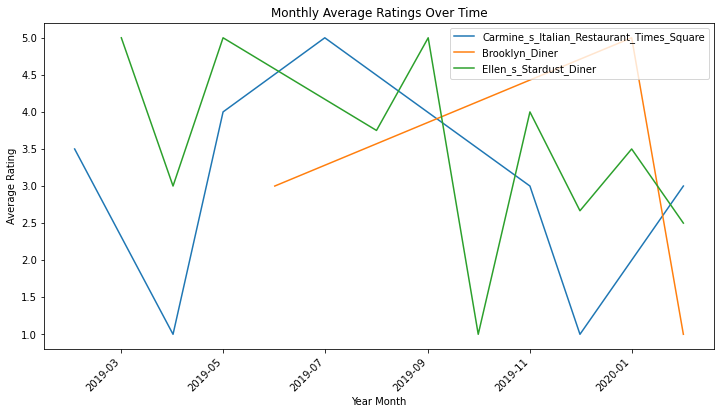

In [54]:
# Get the top n restaurants with most reviews
n = 3
top_restaurants = review_stats['count'].nlargest(n).index

# Print the top restaurants
print("Top Restaurants:", top_restaurants)

# Using function to draw the line plot
# Make sure df_rating_trend and top_restaurants is consistent with the function parameter
avg_rating_trend(df_rating_trend, top_restaurants, [2019, 2020, 2021])

### Most Common Words in Reviews

There are 240283 words in the combination of all reviews.


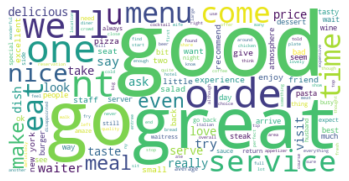

In [52]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Stopwords set
stopwords = set(STOPWORDS)

# Add custom stopwords
stopwords.update(["restaurant", "food", "place", "dinner", "lunch", "breakfast", "table", "NYC", "New York", "drink", "bar"])

# Concatenate all reviews into a single text variable
text = " ".join(str(review) for review in df_test.full_review.dropna())

# Print the number of words in the combined reviews
num_words = len(text.split())
print("There are {} words in the combination of all reviews.".format(num_words))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image using matplotlib
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()